#### **Basic instructions:**
#### 1. **To run code cells**, you can either hit the play button to the left of the cell, or you can select the cell and **press shift-enter**.

#### 2. **The first time** you run this code notebook, you might get a popup asking to choose which version of Python to use (the python "kernel"). **Just hit enter** to choose the base/default version.

#### 3. Make sure you data (.abf) files are in the "data" folder here on the left. You can just copy/paste the files over from where they are saved on your computer.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from utils import *
update_plot_defaults()

# K channels: activation curve

## 1. Choose the data file you want to analyze

#### Put the .abf files with your Na channel recordings in the "data/Na_channels" folder

In [2]:
data_folder = "data/K_channels"

from glob import glob
data_files = glob(data_folder+"/*.abf")
print(data_folder)
data_files

data/K_channels


['data/K_channels/2024_06_08_0007.abf',
 'data/K_channels/2024_06_08_0013.abf',
 'data/K_channels/2024_06_08_0014.abf']

Choose which file you want to analyze and past the file name here:

In [3]:
# data_file = 'data/K_channels/2024_06_08_0013.abf'
data_file = 'data/K_channels/example/K_IV_3.abf'

Now we can load the file and plot the raw data:

Data dimensions (sweeps, channels, timepoints): 
(11, 2, 40000)
sampling freq: 49999.99999999999 Hz


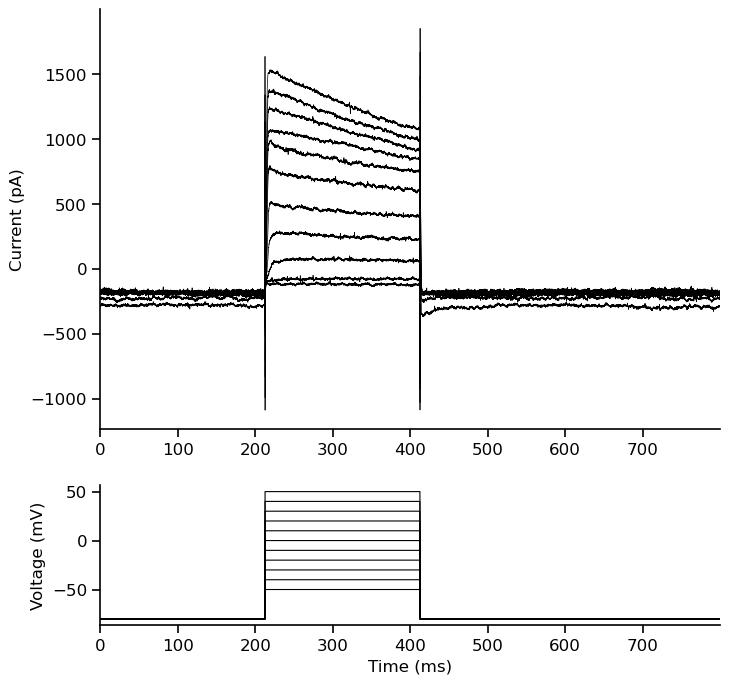

In [4]:
## Extract the sweeps, time and sampling frequency:
sweeps, sweeps_time, sampling_freq = get_sweeps(data_file)

print(f"Data dimensions (sweeps, channels, timepoints): \n{sweeps.shape}")
print(f"sampling freq: {sampling_freq} Hz")

current_traces = sweeps[:, 0, :]
voltage_traces = sweeps[:, 1, :]
ax = plot_traces(sweeps_time*1000, current_traces, voltage_traces)
plt.show()

## 2. Select what you want to measure

### 2.1. Defining the time window

First let's define the relevant time window where we want to measure the currents:

(If you want to save the images, you can do it by clicking on the save icon in the top-right of the image when you hover over it)

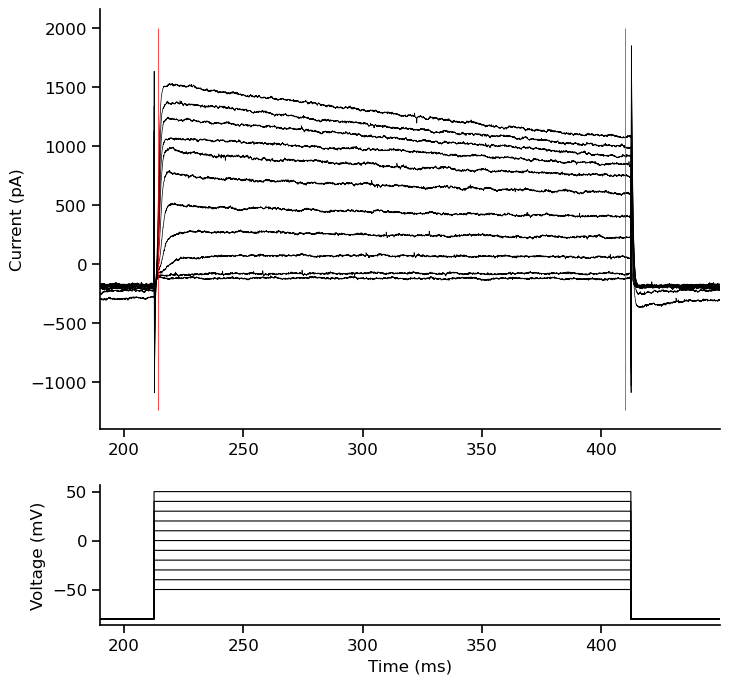

In [5]:
# The start/end time just helps to zoom in on the traces.
start_time = 190  # milliseconds
end_time = 450   # milliseconds, (enter -1 to get the end of the sweep)

# The markers are important: the will define the window where we actually exctract peak current values from. Set them carefully.
marker_1 = 214  # milliseconds
marker_2 = 410    # milliseconds

current_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=0)
voltage_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=1)

ax = plot_traces(time_in_window, current_traces, voltage_traces, marker_1, marker_2)
plt.show()

### 3.1. Optional: apply baseline correction

If your baseline current is not zero, you may need to correct for that to get accurate measurements.

Uncomment this cell block (highlight everything, then cmd+/ on macOS or ctrl+/ on Windows) to run it.

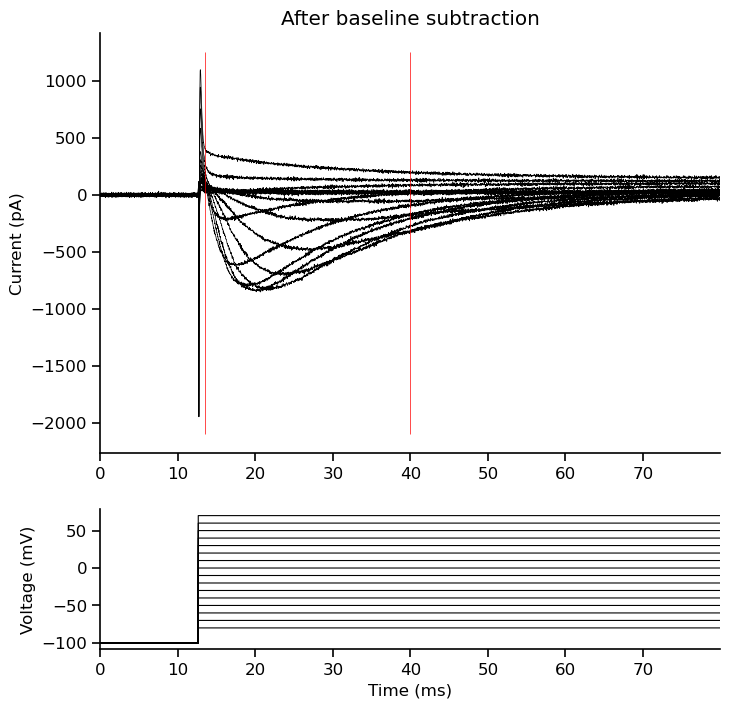

In [ ]:
# Change this to True if you want to subtract the baseline from the sweeps.
subtract_baseline = False

# Measure baseline: you need to specify which part of the trace you want to use for baseline measurement.
start_baseline = 0 # milliseconds
end_baseline = 1 # milliseconds
measurement_type = 'mean' # Options: 'mean', 'max', 'min'


# --------------------------------------------------------------------------------------------------------------------
if subtract_baseline:
    baseline_voltage, baseline_current = get_step_measurements(sweeps, sweeps_time, start_baseline, end_baseline, sampling_freq, measurement_type)

    # Subtract baseline from the sweeps
    num_traces = sweeps.shape[0]
    for i in range(num_traces):
        sweeps[i,0] -= baseline_current[i]

    current_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=0)
    voltage_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=1)
    ax = plot_traces(time_in_window, current_traces, voltage_traces, marker_1, marker_2)
    ax[0].set_title('After baseline subtraction')
    plt.show()

### 3.2. Measure currents

Here we will be using the timepoints from the markers we defined above.

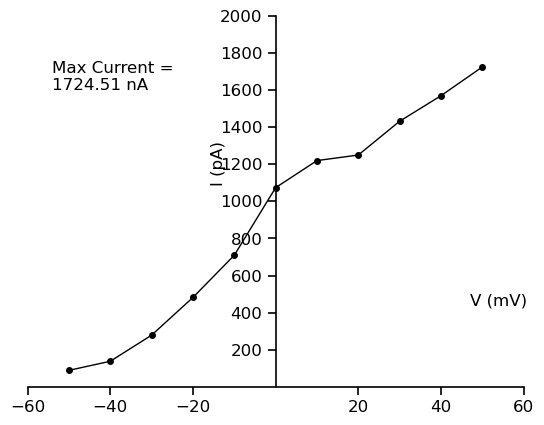

In [ ]:
measurement_type = 'peak' # Options: 'mean', 'max', 'min', 'peak'

voltage_steps, current_steps = get_step_measurements(sweeps, sweeps_time, 
                                                     start_time=marker_1,
                                                     end_time=marker_2,
                                                     sampling_freq=sampling_freq,
                                                     measurement_type=measurement_type)
if np.all(voltage_steps == voltage_steps[0]):
    print("WARNING: All voltage steps are the same")
if np.all(current_steps == current_steps[0]):
    print("WARNING: All current steps are the same")
ax = plot_IV(voltage_steps, current_steps, xlabel_coords=(0.95,0.25), ylabel_coords=(0.4,0.6))

I_max = np.max(current_steps)
ax.text(0.05, 0.8, f'Max Current = \n{I_max:.2f} nA', transform=ax.transAxes)
plt.show()

### 3.3. Get K activation curve and fit Boltzmann (sigmoid) 

We will be fitting this function (Boltzmann equation) to your data points:
$$ \frac{I}{I_{\text{max}}} = I_{norm} = \frac{1}{1 + \exp\left(\frac{V_{\text{half}} - V}{k}\right)}$$

V_half = -3.64 mV, k = 17.50


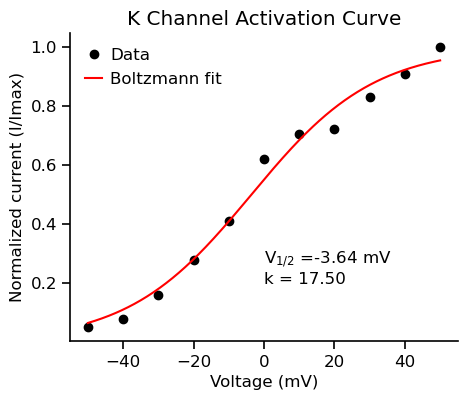

In [15]:
I_norm = current_steps / np.max(current_steps)

# Fit the Boltzmann function (sigmoidal curve) to the data and overlay
from scipy.optimize import curve_fit
def boltzmann(V, V_half, k):
    return 1 / (1 + np.exp((V_half - V) / k))
k_guess = 5 # Initial guess for the slope parameter to fit the curve
popt, _ = curve_fit(boltzmann, voltage_steps, I_norm, p0=[np.median(voltage_steps), k_guess])
V_half_fit, k_fit = popt
V_fit = np.linspace(np.min(voltage_steps), np.max(voltage_steps), 500)
I_fit = boltzmann(V_fit, V_half_fit, k_fit)
print(f"V_half = {V_half_fit:.2f} mV, k = {k_fit:.2f}")

# Plot normalized data points & fitted curve
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(voltage_steps, I_norm, 'o', label='Data', color='black')
ax.plot(V_fit, I_fit, '-', label='Boltzmann fit', color='red')
ax.text(0.5, 0.3, 'V$_{1/2}$ ='+f'{V_half_fit:.2f} mV \nk = {k_fit:.2f}', transform=ax.transAxes, ha='left', va='top')
ax.set_xlabel('Voltage (mV)')
ax.set_ylabel('Normalized current (I/Imax)')
ax.set_title('K Channel Activation Curve')
ax.legend(handlelength=1, loc='upper left', handletextpad=0.5)
plt.show()

### 3.4. Fit exponential curve to get the rise timeconstant

First let's define the relevant time window where we want to fit

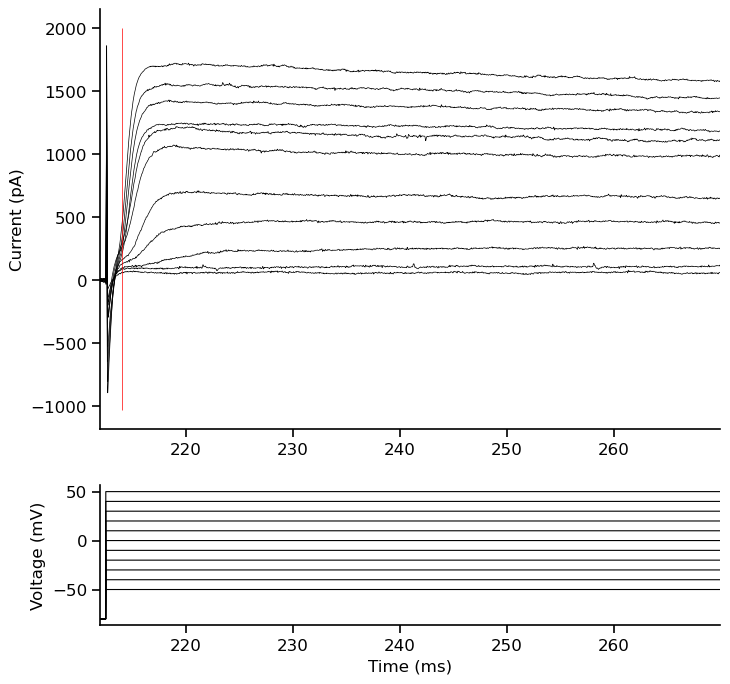

In [16]:
# The start/end time just helps to zoom in on the traces.
start_time = 212  # milliseconds
end_time = 270   # milliseconds, (enter -1 to get the end of the sweep)

# The markers are important: the will define the window where we actually exctract peak current values from. Set them carefully.
marker_1 = 214  # milliseconds
marker_2 = 410    # milliseconds

current_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=0)
voltage_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=1)

# Get the peak value for each trace, and fit the exponential from the start to the peak
current_between_markers, time_between_markers = select_sweep_window(sweeps, sweeps_time, marker_1, marker_2, sampling_freq, channel=0)
voltage_between_markers, time_between_markers = select_sweep_window(sweeps, sweeps_time, marker_1, marker_2, sampling_freq, channel=1)

ax = plot_traces(time_in_window, current_traces, voltage_traces, marker_1, marker_2)
plt.show()

Now we can apply the exponential fit and overlay on our data to see how well it fits.

In [10]:
# If there are any traces we want to exclude, we can do that here:
# (e.g. exclude traces where we can't get a good measurement of tau)
# traces_to_exclude = [0,1,2]
traces_to_exclude = []

trace_idx = np.array([i for i in range(len(current_between_markers)) if i not in traces_to_exclude])
current_between_markers = current_between_markers[trace_idx]
voltage_between_markers = voltage_between_markers[trace_idx]

/var/folders/q9/g15z8pxs2fd8tgyd9ggfv1c8x5w4qx/T/ipykernel_7396/1480450122.py:18: OptimizeWarning: Covariance of the parameters could not be estimated
  fit_params,_ = curve_fit(exponential_curve, time_ms[0:peak_index], trace[0:peak_index],


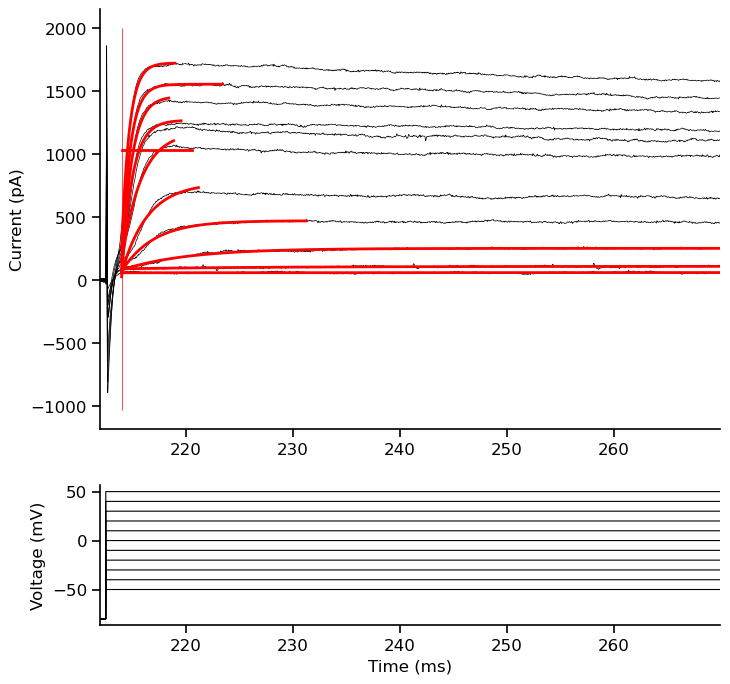

In [11]:
# We need an initial guess for fitting the exponential curve
# (if the fit doesn't work, try to change this value))
tau_guess = 110 # milliseconds

ax = plot_traces(time_in_window, current_traces, voltage_traces, marker_1, marker_2)

def exponential_curve(time, V0, tau, V_inf):
    return V0 * np.exp(-time / tau) + V_inf

tau_values = []
for trace in current_between_markers:
    time_ms = time_between_markers
    peak_value = np.max(trace)
    peak_index = np.argmax(trace)
    V0_guess = trace[0]
    Vinf_guess = peak_value
    try:
        fit_params,_ = curve_fit(exponential_curve, time_ms[0:peak_index], trace[0:peak_index], 
                                    p0=[V0_guess, tau_guess, Vinf_guess], maxfev=1000000)
        V0_fit, tau_fit, Vinf_fit = fit_params
        tau_values.append(tau_fit)

        # Overlay fit
        fit_trace = exponential_curve(time_ms[0:peak_index], *fit_params)
        ax[0].plot(time_ms[0:peak_index], fit_trace[0:peak_index], color='r', alpha=1, linewidth=2)
    except RuntimeError:
        print("Error fitting trace")
        tau_values.append(np.nan)
        continue

    if tau_values[-1] > 1000:
        tau_values[-1] = np.nan
plt.show()


Finally, let's plot the the rise timeconstant vs the voltage steps applied.

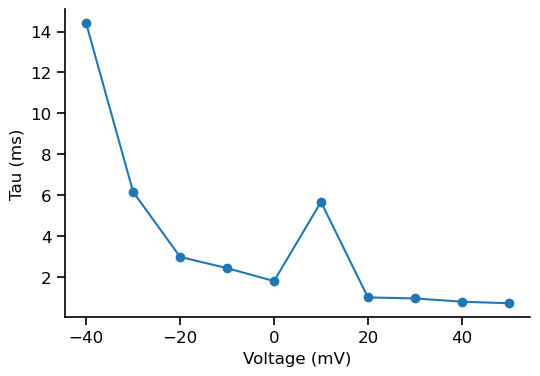

In [12]:
voltage_steps = voltage_between_markers[:, 0]

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(voltage_steps, tau_values, 'o-')
ax.set_ylabel('Tau (ms)')
ax.set_xlabel('Voltage (mV)')
plt.show()